In [1]:
from bs4 import BeautifulSoup
import re, pandas as pd
from selenium import webdriver
#import sys, os
import json
#import time
from wordcloud import WordCloud, STOPWORDS
from matplotlib import pyplot as plt
from pprint import pprint

In [2]:
def get_soup(url):
    """
    Given the url of a page, this function returns the soup object.
    
    Arguments:
    url -- the link to get soup object for
    
    Returns:
    soup - soup object
    """
    driver = webdriver.Firefox()
    driver.get(url)
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    driver.close()
    
    return soup

In [3]:
def grab_job_links(soup):
    """
    Grab all non-sponsored job posting links from a Indeed search result page using the given soup object
    
    Arguments:
    soup -- the soup object corresponding to a search result page
            e.g. https://ca.indeed.com/jobs?q=data+scientist&l=Toronto&start=20
    
    Returns:
    urls -- a python list of job posting urls
    
    """
    urls = []
    
    # Loop thru all the posting links
    for link in soup.find_all('h2', {'class': 'jobtitle'}):
        # Since sponsored job postings are represented by "a target" instead of "a href", no need to worry here
        partial_url = link.a.get('href')
        # This is a partial url, we need to attach the prefix
        url = 'https://ca.indeed.com' + partial_url
        # Make sure this is not a sponsored posting
        urls.append(url)
    
    return urls

In [17]:
def get_urls(query, num_pages, location):
    """
    Get all the job posting URLs resulted from a specific search.
    
    Arguments:
    query -- job title to query
    num_pages -- number of pages needed
    location -- city to search in
    
    Returns:
    urls -- a list of job posting URL's
    """
    # We always need the first page
    base_url = 'https://ca.indeed.com/jobs?q={}&l={}'.format(query, location)
    soup = get_soup(base_url)
    urls = grab_job_links(soup)
    
    # Get the total number of postings found 
    posting_count_string = soup.find(name='div', attrs={'id':"searchCount"}).get_text()
    posting_count = int(posting_count_string[posting_count_string.find('of')+2:].strip())
    # Limit nunmber of pages to get
    max_pages = round(posting_count / 10) - 3
    if num_pages > max_pages:
        return max_pages
    
        # Additional work is needed when more than 1 page is requested
    if num_pages >= 2:
        # Start loop from page 2 since page 1 has been dealt with above
        for i in range(2, num_pages+1):
            num = (i-1) * 10
            base_url = 'https://ca.indeed.com/jobs?q={}&l={}&start={}'.format(query, location, num)
            soup = get_soup(base_url)
            # We always combine the results back to the list
            urls += grab_job_links(soup)

    # Check to ensure the number of urls gotten is correct
    assert len(urls) == num_pages * 10, "There are missing job links, check code!"

    return urls     

In [18]:
def get_posting(url):
    """
    Get the text portion including both title and job description of the job posting from the given url
    
    Arguments:
    url -- The job posting link
        
    Returns:
    title -- the job title (if "data scientist" is in the title)
    posting -- the job posting content    
    """
    # Get the url content as BS object
    soup = get_soup(url)
    
    # First check whether the title is Data Scientist - this info is held in the h3 tag
    try: # Avoid AttributeError when there's no title
        title = soup.find(name='h3').getText().lower()
        posting = soup.find(name='div', attrs={'class': "jobsearch-JobComponent"}).get_text()
        return title, posting.lower()
    
    except:
        return False
        
    #if 'data scientist' in title:  # We'll proceed to grab the job posting text if the title is correct
        # All the text info is contained in the div element with the below class, extract the text.
        #posting = soup.find(name='div', attrs={'class': "jobsearch-JobComponent"}).get_text()
        #return title, posting.lower()
    #else:
        #return False
    
        # Get rid of numbers and symbols other than given
        #text = re.sub("[^a-zA-Z'+#&]", " ", text)
        # Convert to lower case and split to list and then set
        #text = text.lower().strip()
    
        #return text

In [24]:
def get_all_postings(query, num_pages, location='Toronto'):
    """
    Run the search using given query and specified number of pages, store results in a dict.
    
    Arguments:
    query -- Indeed query keyword such as 'Data Scientist'
    num_pages - Number of search results needed
    location -- location to search for
    
    Returns:
    postings_dict -- Python dict including all posting data
    
    """
    
    postings_dict = {}
    urls = get_urls(query, num_pages, location)
    
    if isinstance(urls, list):
        num_urls = len(urls)
        
        for i, url in enumerate(urls):
            if get_posting(url):
                title, posting = get_posting(url)
                postings_dict[i] = {}
                postings_dict[i]['title'], postings_dict[i]['posting'], postings_dict[i]['url'] = \
                title, posting, url
            
            percent = (i+1) / num_urls
            print("Progress: {:2.0f}%".format(100*percent), end='\r')

        return postings_dict

    print("Due to similar results, maximum number of pages is only {}. Please try again!".format(urls))

In [112]:
def plot_wc(text, max_words=200, stopwords_list=[], to_file_name=None):
    """
    Make a word cloud plot using the given text.
    
    Arguments:
    text -- the text as a string
    
    Returns:
    None    
    """
    wordcloud = WordCloud().generate(text)
    stopwords = set(STOPWORDS)
    stopwords.update(stopwords_list)

    wordcloud = WordCloud(background_color='white',
                         stopwords=stopwords,
                         prefer_horizontal=1,
                         max_words=max_words, 
                         min_font_size=6,
                         scale=1,
                         width = 800, height = 800, 
                         random_state=8).generate(text)
    plt.figure(figsize=[16,16])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    if to_file_name:
        to_file_name = to_file_name + ".png"
        wordcloud.to_file(to_file_name)

In [30]:
data = get_all_postings('data+scientist', 30)

In [34]:
len(data)

300

In [32]:
with open('postings.json', 'w') as f:
    json.dump(data, f)

In [33]:
with open('postings.json', 'r') as f:
    postings_dict = json.load(f)

In [47]:
# Check the job titles
[d['title'] for d in data.values()]

['data scientist',
 'data scientist- machine learning',
 'data scientist i',
 'post 1011: data scientist',
 'data scientist',
 'data scientist ii, machine intelligence',
 'data scientist / actuary',
 'data scientist',
 'data scientist, finance',
 'data scientist',
 'data scientist, finance',
 'data scientist',
 'data scientist',
 'data scientist - toronto',
 'data scientist - machine learning',
 'data scientist',
 'data scientist',
 'data scientist',
 'data mining scientist',
 'data scientist, wealth management applied analytics and innovation',
 'data scientist, wealth management applied analytics and innovation',
 'junior data scientist - coop (toronto, on)',
 'data scientist',
 'data scientist',
 'data scientist: advanced analytics',
 'senior data scientist - medical underwriting',
 'data scientist',
 'data scientist, client insights',
 'formulation scientist',
 'data scientist',
 'data scientist i-can',
 'data scientist',
 'data scientist',
 'formulation scientist',
 'data science 

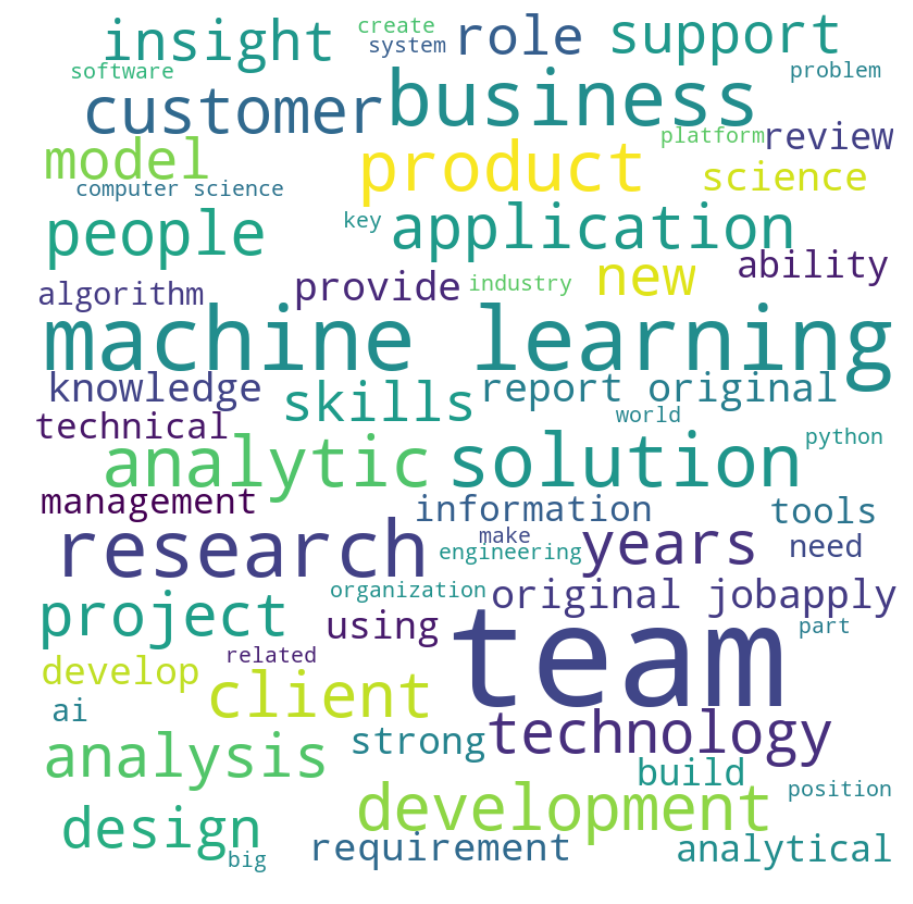

In [113]:
# Take the first 100 postings and make a wordcloud plot
text = []
for i in range(1, 101):
    text.append(data[i]['posting'])
text = " ".join(text)
plot_wc(text, max_words=60, 
        stopwords_list=stopwords_list, 
        to_file_name='wc_raw')

Since we only need the most common terms across job postings, we can use sets to remove additional repetition within each posting.

In [105]:
def clean_text(text):
    """
    Clean the text so that all words are root...
    
    Arguments:
    text -- list of job posting strings
        
    Returns:
    cleaned_text -- a text string for the wc plot
    """
    
    text = [set(i.split()) for i in text]
    
    cleaned_text = set()
    for s in text:
        cleaned_text.update(s)
    cleaned_text = ' '.join(cleaned_text)
    
    return cleaned_text   

In [114]:
stopwords_list = ['ago', 'based', 'canada', 'candidate', 'company', 'data', 'days', 'education',
                  'employee', 'ensure', 'environment', 'et', 'etc', 'experience', 'help', 'including', 
                  'job', 'life', 'location', 'microsoft', 'nowapply', 'office', 'preferred', 'qualifications', 'required', 'requirement',
                  'resume', 'review',
                  'reviewsread', 'save', 'saying', 'scientist', 'self', 'service', 'sitesave', 'skill', 'skills', 'time', 'tool', 
                  'toronto', 'understanding', 
                      'well', 'will', 'work', 'working', 'world', 'year', 'yearsjobapply']

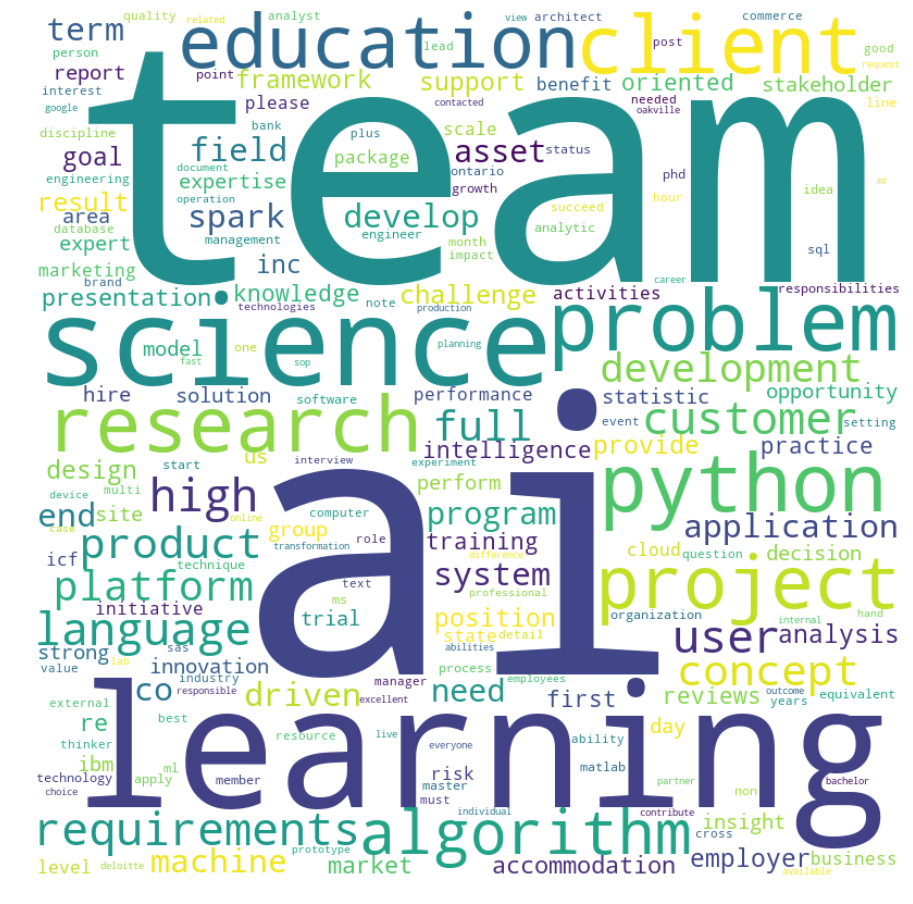

In [115]:
# Take the first 100 postings and make a wordcloud plot
text = []
for i in range(1, 101):
    text.append(data[i]['posting'])
text = clean_text(text)
plot_wc(text, max_words=200, 
        stopwords_list=stopwords_list, 
        to_file_name="wc_cleaned")

In [97]:
text = [set(i.split()) for i in text]

In [99]:
cleaned_text = set()

## Todo's
- stemming etc.
- docstring and comments
- OOP
